In [1]:
import re

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def extract_data(filename):
    with open(filename) as infile:
        content = infile.read()
    
    model = re.findall(r'Model\s*:\s*(.*)', content)
    wer = re.findall(r'WER\s*:\s*(.*)', content)
    rtf = re.findall(r'RTF\s*:\s*(.*)', content)
    memory = re.findall(r'GPU memory while loaded \[MB\]\s*:\s*(.*)', content)

    data = {
        'model': model,
        'wer': wer,
        'rtf': rtf,
        'memory': memory
    }

    return pd.DataFrame(data)



In [3]:
data = extract_data('whisper_results.txt')
models = data['model'].unique()

tiny_flash = data[data['model'] == models[0]].reset_index(drop=True)
base_flash = data[data['model'] == models[1]].reset_index(drop=True)
small_flash = data[data['model'] == models[2]].reset_index(drop=True)
medium_flash = data[data['model'] == models[3]].reset_index(drop=True)
large_flash = data[data['model'] == models[4]].reset_index(drop=True)
tiny = data[data['model'] == models[5]].reset_index(drop=True)
base = data[data['model'] == models[6]].reset_index(drop=True)
small = data[data['model'] == models[7]].reset_index(drop=True)
medium = data[data['model'] == models[8]].reset_index(drop=True)
large = data[data['model'] == models[9]].reset_index(drop=True)

models = [tiny_flash, base_flash, small_flash, medium_flash, large_flash, tiny, base, small, medium, large]

for model in models:
    model.index = model.index + 1

# rename all models by removing openai/whisper- prefix
for model in models:
    model['model'] = model['model'].str.replace('openai/whisper-', '')

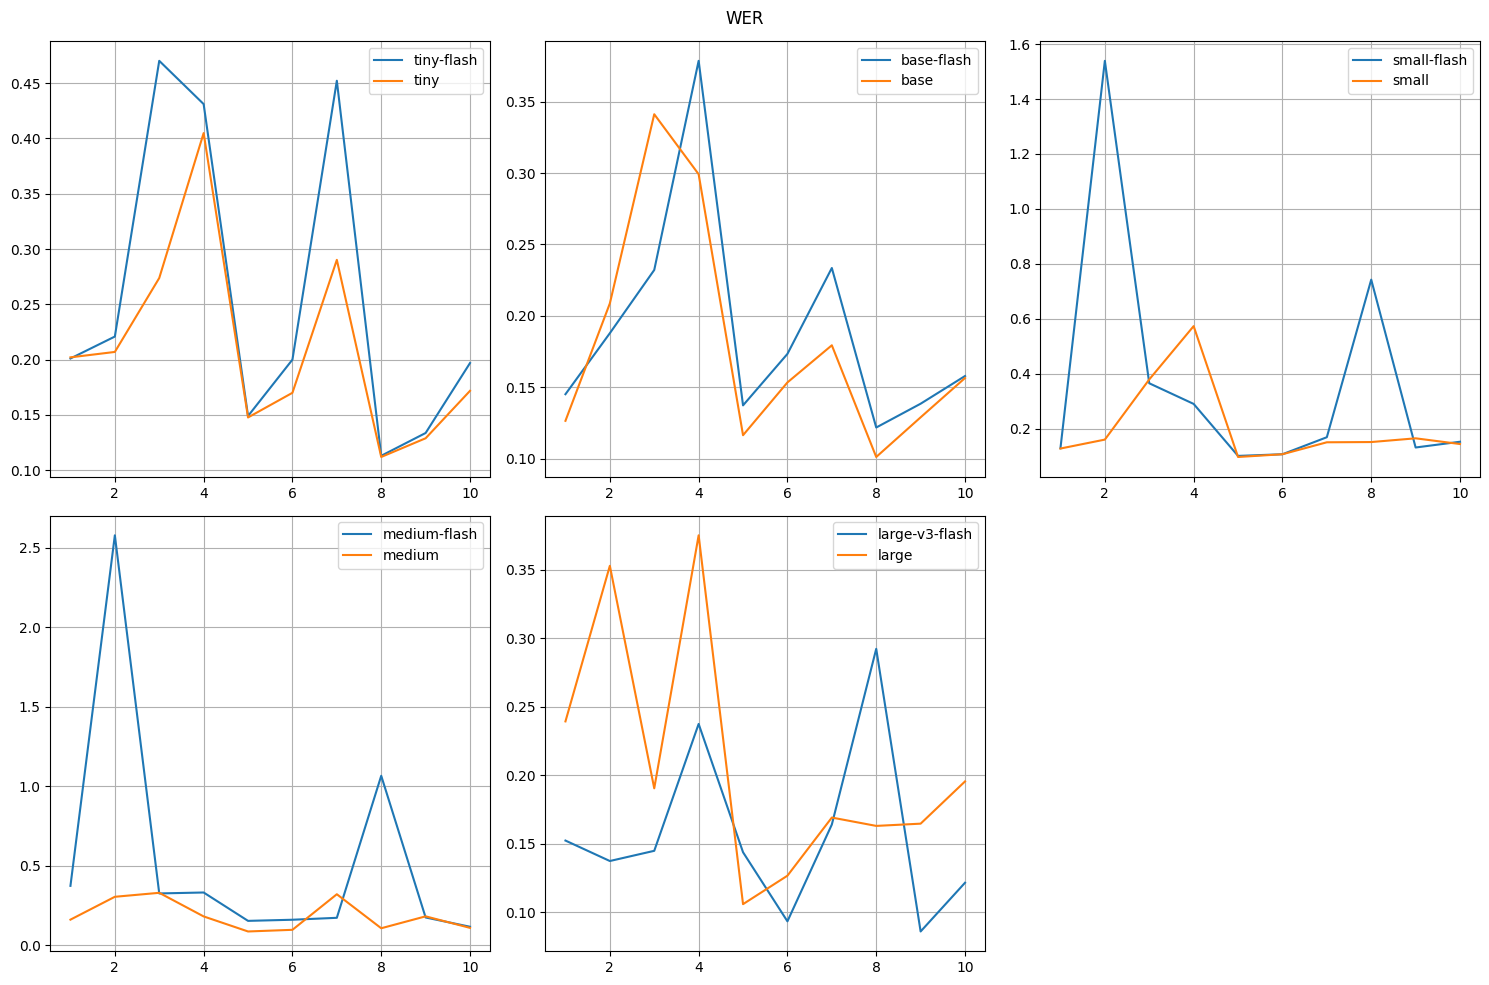

In [15]:
# plot wer

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot the first five subplots
for i in range(5):
    row = i // 3
    col = i % 3
    models[i]['wer'].astype(float).plot(ax=axs[row, col], label=models[i]['model'][1])
    models[i+len(models)//2]['wer'].astype(float).plot(ax=axs[row, col], label=models[i+len(models)//2]['model'][1])
    axs[row, col].grid()
    axs[row, col].legend()

# Remove the last subplot
fig.delaxes(axs[1, 2])

# Remove titles over the subplots
for ax in axs.flat:
    ax.set_title('')

# Create one big title for the full figure
fig.suptitle('WER')

plt.tight_layout()
plt.show()

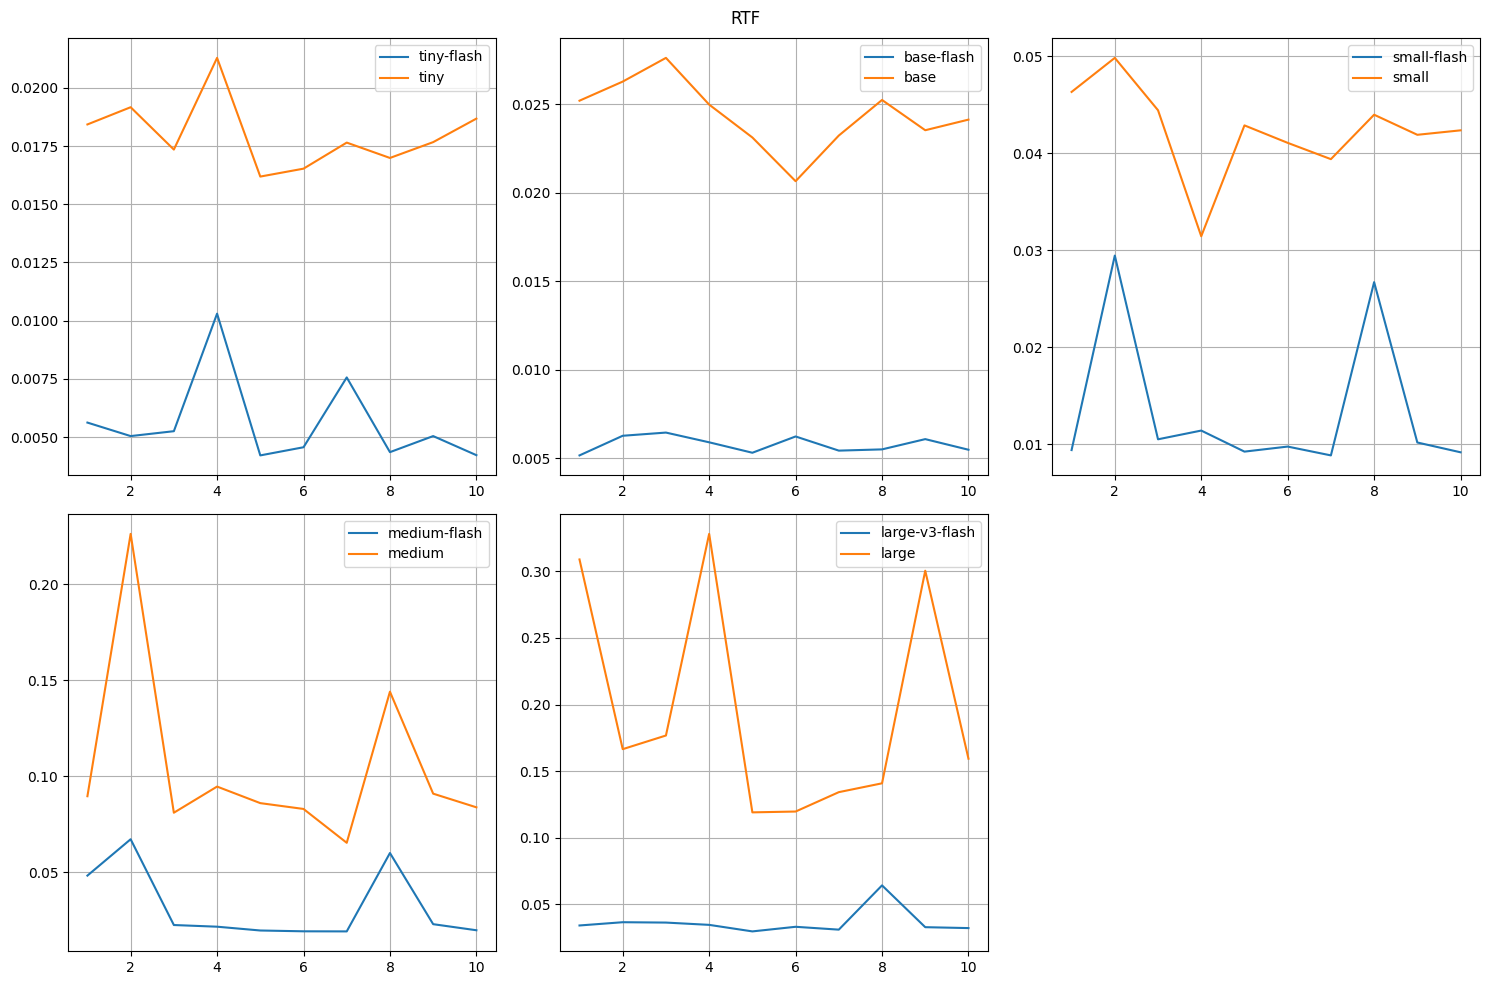

In [16]:
# plot rtf

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot the first five subplots
for i in range(5):
    row = i // 3
    col = i % 3
    models[i]['rtf'].astype(float).plot(ax=axs[row, col], label=models[i]['model'][1])
    models[i+len(models)//2]['rtf'].astype(float).plot(ax=axs[row, col], label=models[i+len(models)//2]['model'][1])
    axs[row, col].grid()
    axs[row, col].legend()

# Remove the last subplot
fig.delaxes(axs[1, 2])

# Remove titles over the subplots
for ax in axs.flat:
    ax.set_title('')

# Create one big title for the full figure
fig.suptitle('RTF')

plt.tight_layout()
plt.show()


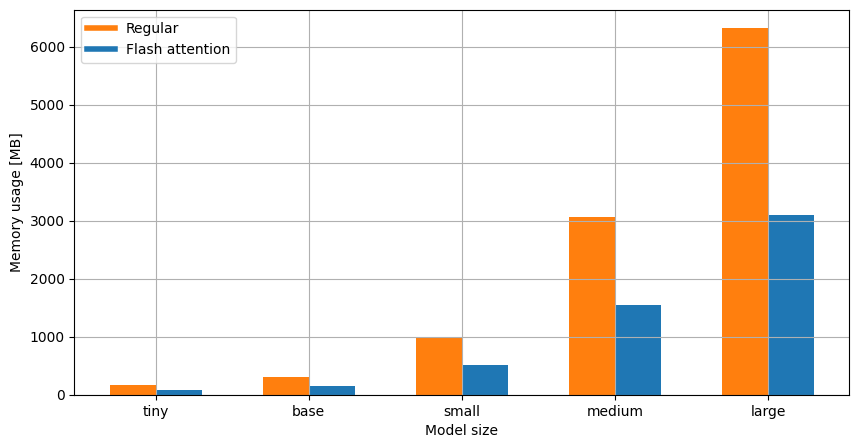

In [26]:
# plot memory



fig, ax = plt.subplots(figsize=(10, 5))

# Define the width of the group
width = 0.3

# Separate models into two groups
models_regular = [model for model in models if 'flash' not in model['model'][1]]
models_flash = [model for model in models if 'flash' in model['model'][1]]

# Plot regular models
for i, model in enumerate(models_regular):
    ax.bar(i - width/2, model['memory'].astype(float), width, color='tab:orange')

# Plot flash models
for i, model in enumerate(models_flash):
    ax.bar(i + width/2, model['memory'].astype(float), width, color='tab:blue')

# Set the x-ticks to be the middle of the groups
ax.set_xticks(range(len(models)//2))
ax.set_xticklabels([model['model'][1] for model in models_regular])
ax.set_xlabel('Model size')
ax.set_ylabel('Memory usage [MB]')

# Create a custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:orange', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
ax.legend(custom_lines, ['Regular', 'Flash attention'])

ax.grid()

plt.show()

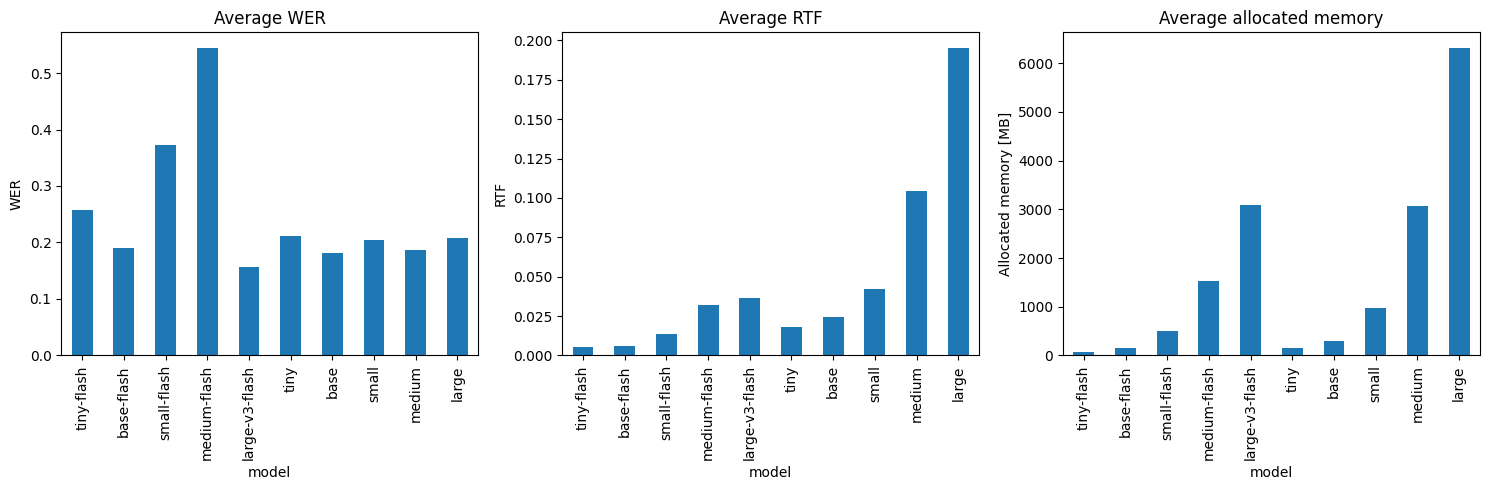

In [27]:
# compute average wer, rtf and memory for all models and plot the wer's, rtf's and memories against each other

wer = []
rtf = []
memory = []

for model in models:
    wer.append(model['wer'].astype(float).mean())
    rtf.append(model['rtf'].astype(float).mean())
    memory.append(model['memory'].astype(float).mean())

data = {
    'model': [model['model'][1] for model in models],
    'wer': wer,
    'rtf': rtf,
    'memory': memory
}

data = pd.DataFrame(data)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

data.plot(x='model', y='wer', kind='bar', ax=axs[0])
axs[0].set_title('Average WER')
axs[0].set_ylabel('WER')
# axs[0].grid()

data.plot(x='model', y='rtf', kind='bar', ax=axs[1])
axs[1].set_title('Average RTF')
axs[1].set_ylabel('RTF')
# axs[1].grid()

data.plot(x='model', y='memory', kind='bar', ax=axs[2])
axs[2].set_title('Average allocated memory')
axs[2].set_ylabel('Allocated memory [MB]')
# axs[2].grid()

# remove the legend
for ax in axs:
    ax.get_legend().remove()


plt.tight_layout()
plt.show()